## MSAE training and feature analysis

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [2]:
"""Import packages."""

import math
import os
import h5py
from datetime import datetime
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple
import temporaldata as td

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from temporaldata import Data
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from mini import train as mt
from mini.util import vec_r2

In [3]:
# Set max rows and cols for df display
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

In [4]:
def clean_session_data(session):
    """Clean session data by filtering trials and spikes based on quality criteria."""
    
    # Mark Churchland gave me a matlab script which I have converted to python

    num_trials = len(session.trials.start)
    # I think is_valid is already defined by brainsets as (session.trials.discard_trial == 0) & (session.trials.task_success == 1) so it's a bit redundant but including it all just to be sure
    # In theory I should also filter based on whether the maze was possible or not (a field called "unhittable") but I cannot find this in the data, perhaps this has already been done in this release of the data
    good_trials = (session.trials.trial_type > 0) & (session.trials.is_valid == 1) & (session.trials.discard_trial == 0) &(session.trials.novel_maze == 0) & (session.trials.trial_version < 3) 
    session.trials = session.trials.select_by_mask(good_trials)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out extraneous trials, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    success = (session.trials.task_success == 1)
    session.trials = session.trials.select_by_mask(success)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out unsuccessful trials, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    post_move = 0.8 # to be kept, there must be at least this many ms after the movement onset
    long_enough = (session.trials.end - session.trials.move_begins_time >= post_move) # should essentially always be true for successes
    session.trials = session.trials.select_by_mask(long_enough)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out trials that were too short, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    consistent = (session.trials.correct_reach == 1)
    session.trials = session.trials.select_by_mask(consistent)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out trials with inconsistent reaches (not similar enough to the \"prototypical\" trial), went from", num_trials, "trials to", new_num_trials)

    primary_conditions = np.unique(session.trials.maze_condition)
    num_conditions = len(primary_conditions)
    print("Number of primary conditions:", num_conditions)
    # Check to make sure they are monotonic, starting from 1 and counting up
    if min(primary_conditions) != 1 or len(np.unique(np.diff(primary_conditions))) != 1:
        raise ValueError("Primary conditions are not monotonic or do not start from 1")

    # In theory I should filter units based on a ranking from 1-4 but I cannot find the ranking in the data, perhaps this has already been done in this release of the data

    # Only keep spikes that are within the cleaned trials
    session.spikes = session.spikes.select_by_interval(session.trials)
    session.hand = session.hand.select_by_interval(session.trials)
    session.eye = session.eye.select_by_interval(session.trials)

    # Convert session recording date to timestamp
    session.session.recording_date = datetime.strptime(session.session.recording_date, '%Y-%m-%d %H:%M:%S')
    session.session.recording_date = session.session.recording_date.timestamp()
    
    return session

In [5]:
# Path to your data directory
data_path = r"C:\Users\pouge\Documents\mini_data\brainsets\processed\churchland_shenoy_neural_2012"
# data_path = "/ceph/aeon/aeon/SANe/brainsets_data/processed/churchland_shenoy_neural_2012"
data_path = Path(data_path)

# List all h5 files in the directory
h5_files = [f for f in os.listdir(data_path) if f.endswith('.h5')]
print(f"Available h5 files: {h5_files}")

# User parameters
subject_name = "jenkins"  # Change to "nitschke" or "jenkins"
num_files_to_load = 1     # Change to desired number of files

# Filter files by subject
subject_files = [f for f in h5_files if subject_name.lower() in f.lower()]
print(f"\nFiles for subject {subject_name}: {subject_files}")

if len(subject_files) == 0:
    print(f"No files found for subject {subject_name}")
elif len(subject_files) < num_files_to_load:
    print(f"Only {len(subject_files)} files available for {subject_name}, loading all of them")
    num_files_to_load = len(subject_files)

# Load and clean the specified number of files
sessions = []
for i in range(min(num_files_to_load, len(subject_files))):
    file_path = os.path.join(data_path, subject_files[i])
    print(f"\nLoading file {i+1}/{num_files_to_load}: {subject_files[i]}")
    
    # Read neural data from HDF5
    with h5py.File(file_path, "r") as f:
        session = Data.from_hdf5(f)

        session.spikes.materialize()
        session.trials.materialize()
        session.hand.materialize()
        session.eye.materialize()
        session.session.materialize()

        print("Session ID: ", session.session.id)
        print("Session subject id: ", session.subject.id)
        print("Session subject sex: ", session.subject.sex)
        print("Session subject species: ", session.subject.species)
        print("Session recording date: ", session.session.recording_date)
        print("Original number of trials:", len(session.trials.start))
        
        # Clean the session data
        session = clean_session_data(session)
        print("Final number of trials after cleaning:", len(session.trials.start))
        
        sessions.append(session)

print(f"\nSuccessfully loaded and cleaned {len(sessions)} sessions for subject {subject_name}")

Available h5 files: ['jenkins_20090912_center_out_reaching.h5', 'jenkins_20090916_center_out_reaching.h5', 'jenkins_20090918_center_out_reaching.h5', 'jenkins_20090923_center_out_reaching.h5', 'nitschke_20090812_center_out_reaching.h5', 'nitschke_20090819_center_out_reaching.h5', 'nitschke_20090910_center_out_reaching.h5', 'nitschke_20090920_center_out_reaching.h5', 'nitschke_20090922_center_out_reaching.h5', 'nitschke_20100923_center_out_reaching.h5']

Files for subject jenkins: ['jenkins_20090912_center_out_reaching.h5', 'jenkins_20090916_center_out_reaching.h5', 'jenkins_20090918_center_out_reaching.h5', 'jenkins_20090923_center_out_reaching.h5']

Loading file 1/1: jenkins_20090912_center_out_reaching.h5
Session ID:  jenkins_20090912_center_out_reaching
Session subject id:  jenkins
Session subject sex:  MALE
Session subject species:  MACACA_MULATTA
Session recording date:  2009-09-12 00:00:00
Original number of trials: 1588
Filtered out extraneous trials, went from 1588 trials to 13

In [7]:
# Parameters
bin_size = 0.05

# Check unit consistency across sessions
unit_ids = np.unique(sessions[0].spikes.unit_index)
for session in sessions:
    unique_units = np.unique(session.spikes.unit_index)
    if not np.array_equal(unique_units, unit_ids):
        raise ValueError("Sessions do not have the same unit IDs. Cannot combine spike data.")

# Determine global bin alignment start point
global_start = min(session.session.recording_date + session.trials.start.min() for session in sessions)
global_start = np.floor(global_start / bin_size) * bin_size  # ensure clean bin alignment

# Collect absolute trial windows across sessions
trial_windows = []
for session in sessions:
    trial_starts = session.trials.start + session.session.recording_date
    trial_ends = session.trials.end + session.session.recording_date
    trial_windows.extend(zip(trial_starts, trial_ends))

trial_windows = np.array(trial_windows)

# Define consistent bin indices across all trial intervals
all_trial_bins = []
for t0, t1 in trial_windows:
    b0 = int(np.floor((t0 - global_start) / bin_size))
    b1 = int(np.ceil((t1 - global_start) / bin_size))
    all_trial_bins.extend(range(b0, b1))

all_trial_bins = np.unique(all_trial_bins)  # remove duplicates and sort

# Convert to consistent timestamps
n_decimals = int(-np.log10(bin_size)) + 1 if bin_size < 1 else 0
consistent_timestamps = np.round(global_start + all_trial_bins * bin_size, n_decimals)

# Accumulator for all binned trials
binned_dfs = []

# Loop over sessions
for session in sessions:
    # Shift spike timestamps to absolute time
    abs_timestamps = session.spikes.timestamps + session.session.recording_date
    unit_ids_this_session = session.spikes.unit_index
    df_spikes = pd.DataFrame({
        'timestamp': abs_timestamps,
        'unit': unit_ids_this_session
    }).sort_values('timestamp')

    # Convert trial times to absolute time
    trial_starts = session.trials.start + session.session.recording_date
    trial_ends = session.trials.end + session.session.recording_date
    df_trials = pd.DataFrame({
        'trial_start': trial_starts,
        'trial_end': trial_ends
    }).sort_values('trial_start')

    # Assign each spike to the most recent trial_start <= timestamp
    df_merged = pd.merge_asof(
        df_spikes,
        df_trials[['trial_start', 'trial_end']],
        left_on='timestamp',
        right_on='trial_start',
        direction='backward'
    )

    # Drop spikes that fall outside their trial interval
    df_merged = df_merged[df_merged['timestamp'] < df_merged['trial_end']]

    # Compute bin index relative to global bin start
    df_merged['bin'] = ((df_merged['timestamp'] - global_start) / bin_size).astype(int)

    # Group by (bin, unit) and count spikes
    df_counts = (
        df_merged
        .groupby(['bin', 'unit'], observed=True)
        .size()
        .reset_index(name='count')
    )

    # Pivot to wide format: units as columns
    spk_cts = df_counts.pivot_table(
        index='bin',
        columns='unit',
        values='count',
        fill_value=0
    )

    # Use consistent trial bins (includes bins with 0 spikes)
    spk_cts = spk_cts.reindex(all_trial_bins, fill_value=0)

    # Convert to consistent timestamps
    spk_cts.index = pd.Index(consistent_timestamps, name='timestamp')
    spk_cts.columns.name = None

    # Collect results
    binned_dfs.append(spk_cts)

# Concatenate all binned trials across sessions
spk_cts_df = pd.concat(binned_dfs)
spk_cts_df = spk_cts_df[~spk_cts_df.index.duplicated()]
spk_cts_df.sort_index(inplace=True)

# Result: each row = time bin, each col = unit, values = spike count
display(spk_cts_df)

0    1    2    3    4    5    6    7    8    9    10   11   ...  \
timestamp                                                                 ...   
1.252739e+09    0    1    5    2    3    0    3    2    3    2    5    5  ...   
1.252739e+09    0    0    2    0    3    0    1    1    3    3    2    6  ...   
1.252739e+09    1    0    1    0    1    0    0    0    3    3    3    4  ...   
1.252739e+09    0    2    2    0    3    0    2    0    2    2    6    2  ...   
1.252739e+09    0    0    1    0    0    1    0    0    1    0    1    0  ...   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1.252748e+09    0    1    2    3    3   10    5    4    7    2    7    2  ...   
1.252748e+09    0    4    7    1    4   10    7    6    8    7    8    4  ...   
1.252748e+09    0    7    3    5    5   11    6    6    6    7    7    6  ...   
1.252748e+09    0    3    7    2    9    9   13    6    6    6    9    8  ...   
1.252748e+09    0    2    0    1    1    2    4    1    1    2    2    4  ...   

              179  180  181  182  183  184  185  186  187  188  189  190  
timestamp                                                                 
1.252739e+09    1    4    3    1    0    5    2    2    2    1    3    0  
1.252739e+09    3    0    0    1    1    0    4    3    1    3    3    1  
1.252739e+09    2    2    2    0    0    0    0    1    2    0    0    3  
1.252739e+09    1    1    1    1    2    0    0    2    1    1    3    0  
1.252739e+09    1    0    0    1    0    0    0    1    0    2    0    0  
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
1.252748e+09    2    4    2    4    3    3    2    4    5    2    3    5  
1.252748e+09    5    4    6    5    4    4    4    6    4    5    4    6  
1.252748e+09    2    1    3    1    1    1    2    3    1    1    3    2  
1.252748e+09    3    0    0    0    2    3    1    0    1    1    0    0  
1.252748e+09    0    0    1    2    1    0    1    1    0    0    0    1  

[70450 rows x 191 columns]

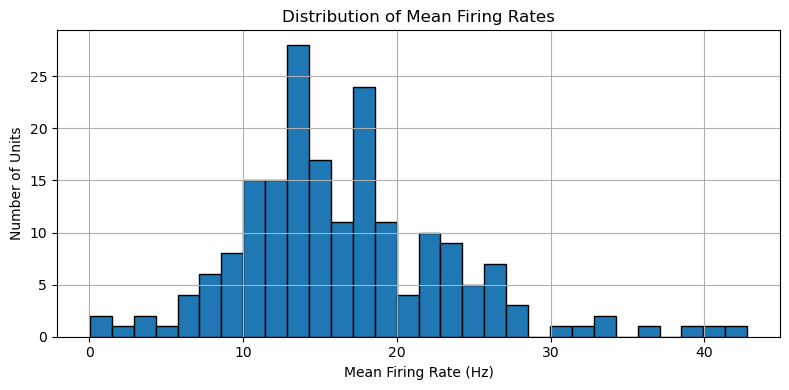

Mean firing rate across units: 16.49 Hz
Median: 15.44 Hz
Range: 0.04–42.78 Hz


In [8]:
# Compute mean firing rate (Hz) per unit
duration_sec = (spk_cts_df.index[-1] - spk_cts_df.index[0]) + bin_size
mean_firing_rates = spk_cts_df.sum(axis=0) / duration_sec  # spikes/sec

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(mean_firing_rates, bins=30, edgecolor='black')
plt.xlabel('Mean Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Mean Firing Rates')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary stats
print("Mean firing rate across units: {:.2f} Hz".format(mean_firing_rates.mean()))
print("Median: {:.2f} Hz".format(np.median(mean_firing_rates)))
print("Range: {:.2f}–{:.2f} Hz".format(mean_firing_rates.min(), mean_firing_rates.max()))


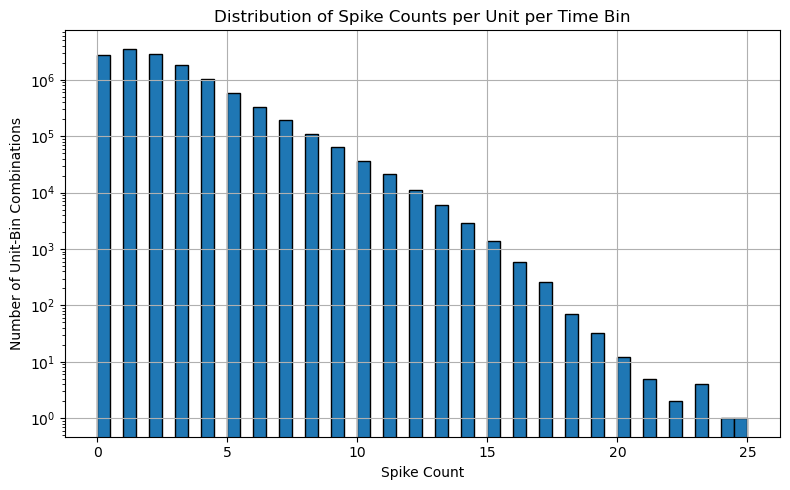

In [9]:
# Flatten the spike count matrix to a 1D array
flattened_spike_counts = spk_cts_df.values.flatten()

# Plot histogram of spike counts
plt.figure(figsize=(8, 5))
plt.hist(flattened_spike_counts, bins=50, edgecolor='black')
plt.title("Distribution of Spike Counts per Unit per Time Bin")
plt.xlabel("Spike Count")
plt.ylabel("Number of Unit-Bin Combinations")
plt.yscale("log")  # Optional: log scale to better visualize skewed distributions
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# # Grab raw arrays
# timestamps = session.spikes.timestamps
# unit_ids = session.spikes.unit_index

# # Parameters
# bin_size = 0.05
# start = timestamps.min()
# end = timestamps.max()
# bins = np.arange(start, end + bin_size, bin_size)

# # Create DataFrame
# df_long = pd.DataFrame({
#     'timestamp': timestamps,
#     'unit': unit_ids
# })

# # Assign each spike to a time bin
# df_long['bin'] = np.digitize(df_long['timestamp'], bins) - 1  # zero-based index

# # Group by bin and unit, then count spikes
# spk_cts_df = (
#     df_long
#     .groupby(['bin', 'unit'])
#     .size()
#     .unstack(fill_value=0)  # unit IDs become columns
# )

# # Convert bin index to actual time (bin start)
# spk_cts_df.index = bins[spk_cts_df.index]
# spk_cts_df.columns.name = None

# # Result: each row = time bin, each col = unit, values = spike count
# display(spk_cts_df)

In [11]:
"""Check sparsity of binned spike counts."""

frac_nonzero_bins = (spk_cts_df != 0).values.sum() / spk_cts_df.size
frac_nonzero_examples = (spk_cts_df.sum(axis=1) > 0).mean()
print(f"{frac_nonzero_bins=:.4f}")
print(f"{frac_nonzero_examples=:.4f}")

frac_nonzero_bins=0.7957
frac_nonzero_examples=0.9999


In [12]:
"""Load spikes and set sae config."""

# gpu for training
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

spk_cts = t.from_numpy(spk_cts_df.to_numpy()).bfloat16().to(device)
spk_cts /= spk_cts.max()  # max normalize spike counts

dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
# dsae_topk_map = {1024: 12, 2048: 24, 4096: 48}
dsae = max(dsae_topk_map.keys())
n_inst = 2

display(spk_cts)

device=device(type='cuda')


tensor([[0.0000, 0.0400, 0.2002,  ..., 0.0400, 0.1201, 0.0000],
        [0.0000, 0.0000, 0.0801,  ..., 0.1201, 0.1201, 0.0400],
        [0.0400, 0.0000, 0.0400,  ..., 0.0000, 0.0000, 0.1201],
        ...,
        [0.0000, 0.2793, 0.1201,  ..., 0.0400, 0.1201, 0.0801],
        [0.0000, 0.1201, 0.2793,  ..., 0.0400, 0.0000, 0.0000],
        [0.0000, 0.0801, 0.0000,  ..., 0.0000, 0.0000, 0.0400]],
       device='cuda:0', dtype=torch.bfloat16)

## Train MSAE

In [13]:

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step: 100%|██████████| 1360/1360 [00:31<00:00, 42.89it/s, loss=0.00615,  l0_mean=24.0, l0_std=8.525715827941895, frac_dead=0.9052734375] 


## Validate SAEs

In [14]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

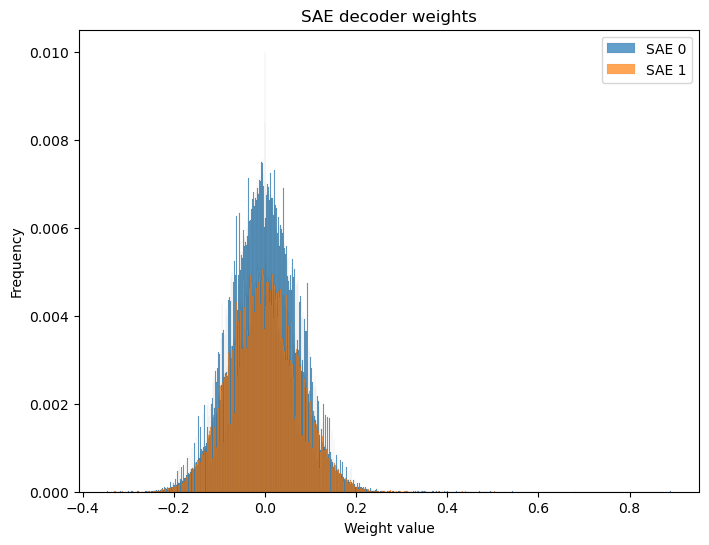

In [15]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step: 100%|██████████| 68/68 [00:00<00:00, 90.31it/s] 


SAE 0: 0.72% of R² (per example) values are negative
SAE 1: 0.57% of R² (per example) values are negative


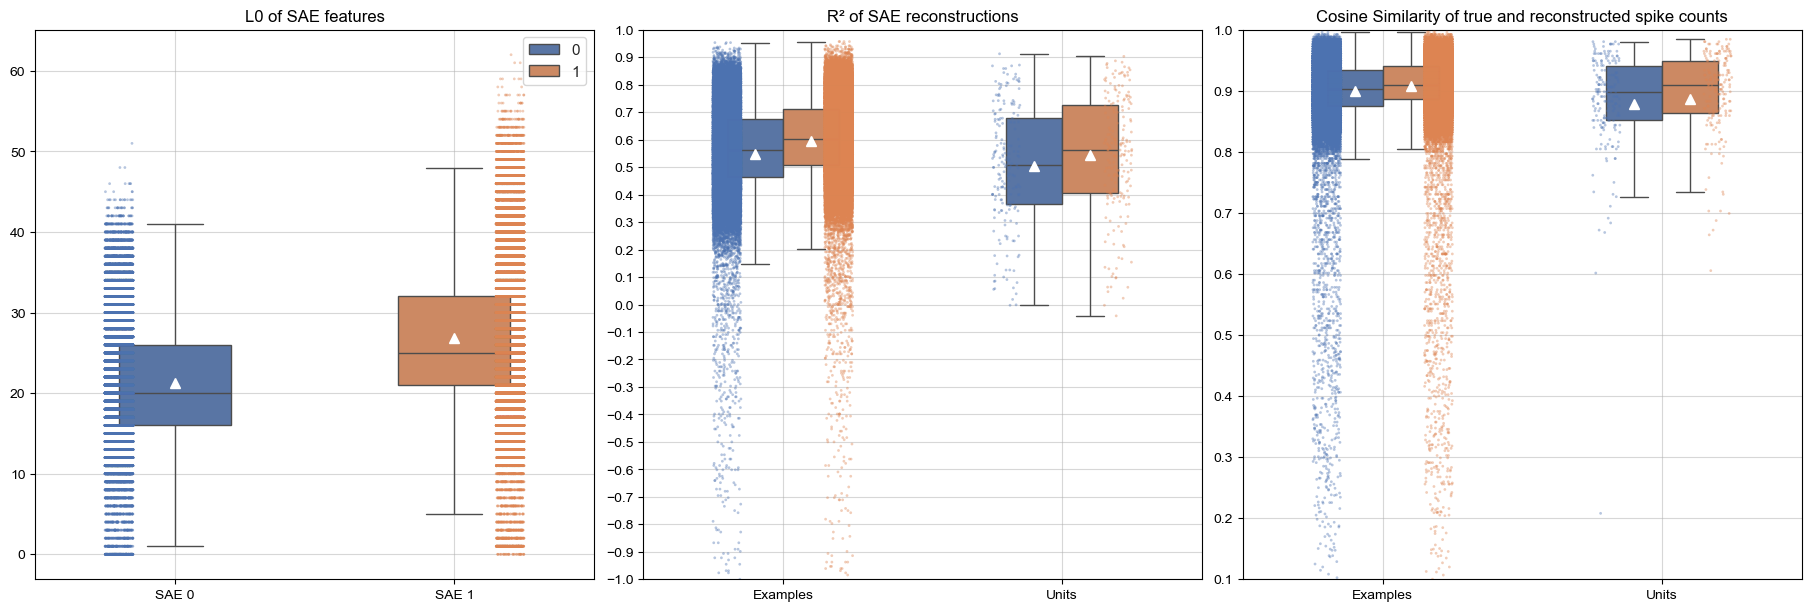

In [16]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

In [17]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.989
SAE instance 1 R² (summed spike count over all units per example) = 0.992


In [18]:
# If cosine similarity is high but r2 is low, it suggests that the model is capturing the structure of the data but not the magnitude.
# Calculate scale ratio of norms to check this

# Expand spk_cts to shape [n_examples, 1, n_units]
spk_cts_exp = spk_cts[:recon_spk_cts.shape[0]].unsqueeze(1)

# Compute norms
true_norms = t.norm(spk_cts_exp, dim=-1)               # shape: [n_examples, 1]
recon_norms = t.norm(recon_spk_cts, dim=-1)            # shape: [n_examples, n_instances]

# Compute scale ratio per example and instance
scale = true_norms / recon_norms                       # shape: [n_examples, n_instances]

print(scale.mean(dim=0))  # if it’s consistently >1 or <1, your model is biased in magnitude

tensor([1.1328, 1.1250], device='cuda:0', dtype=torch.bfloat16)


In [19]:
spk_cts_trimmed = spk_cts[:recon_spk_cts.shape[0]]
bias = (recon_spk_cts - spk_cts_trimmed.unsqueeze(1)).mean(dim=0)
print(bias.mean(dim=0))  # mean bias per unit, averaged across examples

tensor([-0.0006, -0.0026, -0.0019, -0.0022, -0.0024, -0.0037, -0.0019, -0.0021,
        -0.0013, -0.0023, -0.0022, -0.0017, -0.0027, -0.0022, -0.0020, -0.0015,
        -0.0023, -0.0028, -0.0017, -0.0023, -0.0023, -0.0023, -0.0018, -0.0030,
        -0.0020, -0.0021, -0.0014, -0.0021, -0.0002, -0.0026, -0.0013, -0.0025,
        -0.0017, -0.0016, -0.0021, -0.0028, -0.0019, -0.0031, -0.0015, -0.0014,
        -0.0023, -0.0018, -0.0027, -0.0028, -0.0020, -0.0027, -0.0025, -0.0015,
        -0.0020, -0.0014, -0.0026, -0.0024, -0.0019, -0.0022, -0.0019, -0.0010,
        -0.0014, -0.0014, -0.0028, -0.0025, -0.0025, -0.0018, -0.0029, -0.0026,
        -0.0018, -0.0016, -0.0014, -0.0019, -0.0028, -0.0026, -0.0024, -0.0015,
        -0.0023, -0.0016, -0.0023, -0.0023, -0.0024, -0.0014, -0.0012, -0.0021,
        -0.0021, -0.0016, -0.0022, -0.0027, -0.0021, -0.0015, -0.0026, -0.0022,
        -0.0027, -0.0005, -0.0021, -0.0023, -0.0016, -0.0019, -0.0020, -0.0017,
        -0.0022, -0.0017, -0.0016, -0.00

In [20]:
true_var = spk_cts_trimmed.var(dim=0).mean()
pred_var = recon_spk_cts.var(dim=0).mean()
print(f"True variance: {true_var.item():.4f}, Pred variance: {pred_var.item():.4f}")

True variance: 0.0048, Pred variance: 0.0029


### Remove bad units and retrain.

In [21]:

# Set threshold for removing units
r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spk_cts[:, keep_mask]

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

frac units above r2_thresh=0.1: 0.94
Number to keep: 180 / 191


SAE batch training step: 100%|██████████| 1360/1360 [00:34<00:00, 40.00it/s, loss=0.00632,  l0_mean=24.0, l0_std=8.397896766662598, frac_dead=0.90966796875]


SAE batch evaluation step: 100%|██████████| 68/68 [00:00<00:00, 135.63it/s]


SAE 0: 0.65% of R² (per example) values are negative
SAE 1: 0.66% of R² (per example) values are negative
SAE instance 0 R² (summed spike count over all units per example) = 0.993
SAE instance 1 R² (summed spike count over all units per example) = 0.992


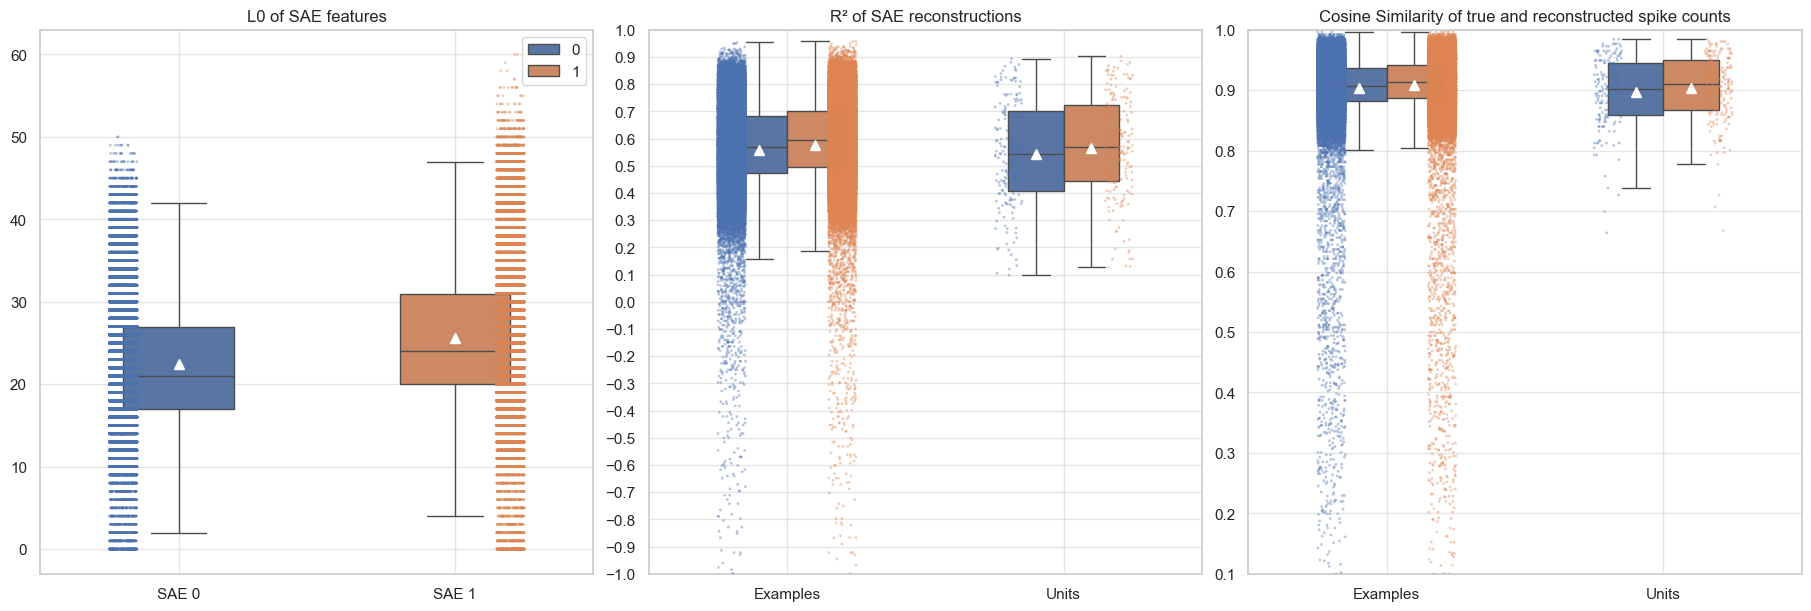

In [22]:
"""Re-Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


## Get environment / behavior (meta)data

In [173]:
# Accumulators
all_hand_dfs = []
all_eye_dfs = []
all_trials_dfs = []

for i, session in enumerate(sessions):# Hand data
    timestamps = session.hand.timestamps.copy()
    timestamps = timestamps + session.session.recording_date
    acc = session.hand.acc_2d
    pos = session.hand.pos_2d
    vel = session.hand.vel_2d
    hand_df = pd.DataFrame({
        'timestamp': timestamps,
        'acc_x': acc[:, 0],
        'acc_y': acc[:, 1],
        'pos_x': pos[:, 0],
        'pos_y': pos[:, 1],
        'vel_x': vel[:, 0],
        'vel_y': vel[:, 1],
    })
    hand_df['session'] = i
    all_hand_dfs.append(hand_df)

    # Eye data 
    timestamps = session.eye.timestamps.copy()
    timestamps = timestamps + session.session.recording_date
    pos = session.eye.pos
    eye_df = pd.DataFrame({
        'timestamp': timestamps,
        'pos_x': pos[:, 0],
        'pos_y': pos[:, 1],
    })
    all_eye_dfs.append(eye_df)

    # Trial data — just add session start time since they already start from 0
    start = session.trials.start.copy() + session.session.recording_date
    end = session.trials.end.copy() + session.session.recording_date
    target_on_time = session.trials.target_on_time.copy() + session.session.recording_date
    go_cue_time = session.trials.go_cue_time.copy() + session.session.recording_date
    move_begins_time = session.trials.move_begins_time.copy() + session.session.recording_date
    move_ends_time = session.trials.move_ends_time.copy() + session.session.recording_date

    trials_df = pd.DataFrame({
        'start': start,
        'end': end,
        'target_on_time': target_on_time,
        'go_cue_time': go_cue_time,
        'move_begins_time': move_begins_time,
        'move_ends_time': move_ends_time,
        'hit_target_position': [tuple(pos) for pos in session.trials.hit_target_position.copy()],
        'maze_condition':   session.trials.maze_condition.copy(),
    })
    all_trials_dfs.append(trials_df)

# Concatenate everything
combined_hand_df = pd.concat(all_hand_dfs, ignore_index=True)
combined_hand_df.set_index('timestamp', inplace=True)
combined_eye_df = pd.concat(all_eye_dfs, ignore_index=True)
combined_eye_df.set_index('timestamp', inplace=True)
combined_trials_df = pd.concat(all_trials_dfs, ignore_index=True)

# Create full timestamp index from hand, eye, and event times
all_event_ts = np.concatenate([
    combined_trials_df['target_on_time'].values,
    combined_trials_df['go_cue_time'].values,
    combined_trials_df['move_begins_time'].values,
    combined_trials_df['move_ends_time'].values,
])
all_ts = np.unique(np.concatenate([
    combined_hand_df.index.values,
    combined_eye_df.index.values,
    all_event_ts
]))
all_ts.sort()

# Create master dataframe with unified timestamp index
metadata = pd.DataFrame(index=all_ts)
metadata.index.name = 'timestamp'

# Merge hand and eye data
metadata = metadata.join(combined_hand_df, how='left')
metadata = metadata.join(combined_eye_df, how='left', rsuffix='_eye')

# Add event column
event_map = {
    'target_on_time': 'target_on',
    'go_cue_time': 'go_cue',
    'move_begins_time': 'move_begins',
    'move_ends_time': 'move_ends',
}
event_col = pd.Series(index=metadata.index, dtype="object")
for col, label in event_map.items():
    event_times = combined_trials_df[col].values
    matched_ts = np.isin(metadata.index.values, event_times)
    event_col.loc[matched_ts] = label
metadata['event'] = event_col

# Add trial_idx column based on start/end intervals
trial_idx_series = pd.Series(index=metadata.index, dtype='float')
for idx, trial in combined_trials_df.iterrows():
    mask = (metadata.index >= trial['start']) & (metadata.index <= trial['end'])
    trial_idx_series.loc[mask] = idx
metadata['trial_idx'] = trial_idx_series
metadata['hit_target_position'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['hit_target_position']
)
metadata['maze_condition'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['maze_condition']
)

# Show result
print("Metadata:")
display(metadata)

Metadata:


acc_x       acc_y       pos_x      pos_y     vel_x  \
timestamp                                                               
1.252739e+09 -318.112010 -349.493909    2.684289 -27.751781  2.029887   
1.252739e+09 -402.998304 -558.682011    2.686319 -27.772957  1.711775   
1.252739e+09 -430.359657 -769.504367    2.687712 -27.794833  1.223890   
1.252739e+09 -395.382562 -689.557801    2.688767 -27.817546  0.851056   
1.252739e+09 -416.602764 -522.552280    2.689415 -27.840964  0.433125   
...                  ...         ...         ...        ...       ...   
1.252748e+09  -86.161716 -162.571905  128.438120  11.822008  2.227196   
1.252748e+09 -123.121809 -141.393377  128.440275  11.821787  2.087106   
1.252748e+09 -125.174352 -102.852460  128.442294  11.821359  1.980952   
1.252748e+09 -125.118804  -84.946567  128.444237  11.820908  1.836757   
1.252748e+09 -106.042665  -79.275781  128.445968  11.820299  1.730715   

                  vel_y  session  pos_x_eye  pos_y_eye event  trial_idx  \
timestamp                                                                 
1.252739e+09 -21.176818        0       -6.0       12.9   NaN        0.0   
1.252739e+09 -21.526312        0       -6.4       11.0   NaN        0.0   
1.252739e+09 -22.294182        0       -7.0       13.1   NaN        0.0   
1.252739e+09 -23.065321        0       -7.1       11.1   NaN        0.0   
1.252739e+09 -23.673298        0       -7.0        9.5   NaN        0.0   
...                 ...      ...        ...        ...   ...        ...   
1.252748e+09  -0.156713        0      178.7      -62.4   NaN     1014.0   
1.252748e+09  -0.324412        0      179.9      -62.2   NaN     1014.0   
1.252748e+09  -0.439499        0      180.1      -63.0   NaN     1014.0   
1.252748e+09  -0.530117        0      179.9      -62.4   NaN     1014.0   
1.252748e+09  -0.609392        0      179.9      -62.8   NaN     1014.0   

             hit_target_position  maze_condition  
timestamp                                         
1.252739e+09           (132, 46)              10  
1.252739e+09           (132, 46)              10  
1.252739e+09           (132, 46)              10  
1.252739e+09           (132, 46)              10  
1.252739e+09           (132, 46)              10  
...                          ...             ...  
1.252748e+09           (132, 46)              12  
1.252748e+09           (132, 46)              12  
1.252748e+09           (132, 46)              12  
1.252748e+09           (132, 46)              12  
1.252748e+09           (132, 46)              12  

[2813145 rows x 13 columns]

In [174]:
# Create metadata_binned with consistent timestamps
metadata_binned = pd.DataFrame(index=pd.Index(consistent_timestamps, name='timestamp'))

# Assign each metadata row to a bin index
bin_ids = np.digitize(metadata.index.values, consistent_timestamps) - 1
bin_ids = np.clip(bin_ids, 0, len(consistent_timestamps) - 1)

# Aggregate 'event' field across binned metadata
event_agg = metadata['event'].groupby(bin_ids).agg(lambda x: ', '.join(x.dropna().astype(str)))
event_agg = event_agg.replace('', np.nan)

# Pull nearest rows for all other metadata columns
metadata_nearest = metadata.reindex(consistent_timestamps, method='nearest')

# Copy all columns from nearest metadata
for col in metadata.columns:
    if col != 'event':
        metadata_binned[col] = metadata_nearest[col].values

# Insert aggregated event strings
metadata_binned['event'] = event_agg.reindex(range(len(consistent_timestamps))).values

# Result: metadata for all trial bins, one row per bin
print("Metadata binned:")
display(metadata_binned)

Metadata binned:


acc_x       acc_y       pos_x      pos_y      vel_x  \
timestamp                                                                
1.252739e+09 -318.112010 -349.493909    2.684289 -27.751781   2.029887   
1.252739e+09 -497.464127 -632.636229    2.852594 -28.756098   1.907928   
1.252739e+09  376.796978 -127.597097    2.207741 -30.821150 -14.462500   
1.252739e+09 -284.046162 -209.016365    1.936817 -32.045630  -0.525935   
1.252739e+09  -89.561862  160.722499    1.807268 -32.479916  -8.481216   
...                  ...         ...         ...        ...        ...   
1.252748e+09 -106.042665  -79.275781  128.445968  11.820299   1.730715   
1.252748e+09 -106.042665  -79.275781  128.445968  11.820299   1.730715   
1.252748e+09 -106.042665  -79.275781  128.445968  11.820299   1.730715   
1.252748e+09 -106.042665  -79.275781  128.445968  11.820299   1.730715   
1.252748e+09 -106.042665  -79.275781  128.445968  11.820299   1.730715   

                  vel_y  session  pos_x_eye  pos_y_eye  trial_idx  \
timestamp                                                           
1.252739e+09 -21.176818        0       -6.0       12.9        0.0   
1.252739e+09 -21.723573        0       -7.1       11.7        0.0   
1.252739e+09 -50.774300        0       -6.0       11.2        0.0   
1.252739e+09  -5.951463        0       -7.6       11.0        0.0   
1.252739e+09  -7.023836        0       -6.1       12.1        0.0   
...                 ...      ...        ...        ...        ...   
1.252748e+09  -0.609392        0      179.9      -62.8     1014.0   
1.252748e+09  -0.609392        0      179.9      -62.8     1014.0   
1.252748e+09  -0.609392        0      179.9      -62.8     1014.0   
1.252748e+09  -0.609392        0      179.9      -62.8     1014.0   
1.252748e+09  -0.609392        0      179.9      -62.8     1014.0   

             hit_target_position  maze_condition event  
timestamp                                               
1.252739e+09           (132, 46)              10   NaN  
1.252739e+09           (132, 46)              10   NaN  
1.252739e+09           (132, 46)              10   NaN  
1.252739e+09           (132, 46)              10   NaN  
1.252739e+09           (132, 46)              10   NaN  
...                          ...             ...   ...  
1.252748e+09           (132, 46)              12   NaN  
1.252748e+09           (132, 46)              12   NaN  
1.252748e+09           (132, 46)              12   NaN  
1.252748e+09           (132, 46)              12   NaN  
1.252748e+09           (132, 46)              12   NaN  

[70450 rows x 13 columns]

## Interpret features

In [67]:
"""Set vars for saving / loading feature act data!"""

load_acts = True  # if True, will load saved feature activations
save_acts = False
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

session_dates = []
for session in sessions:
    session_date = datetime.fromtimestamp(session.session.recording_date)
    session_date = session_date.strftime("%Y%m%d")
    session_dates.append(session_date)
session_dates_str = "_".join(session_dates)
session_dates_str

acts_df_save_path = data_path / f"{subject_name}_{session_dates_str}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [79]:
"""Load feature activations data."""

if load_acts:
    acts_df = pd.read_csv(acts_df_save_path)
    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [93]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [94]:
"""Create df with info per feature."""

# Get a features df from acts df
features_df = acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
features_df["act_mean_over_std"] = features_df["activation_mean"] / features_df["activation_std"]
features_df["activation_frac"] = features_df["activation_count"] / n_recon_examples
features_df = features_df.drop(columns=["activation_count"])
features_df = features_df.dropna().reset_index(drop=True)

if not load_acts:
    # Keep only features from features_df in acts_df
    acts_df = acts_df[acts_df["feature_idx"].isin(features_df["feature_idx"])].reset_index(drop=True)

if save_acts:
    acts_df.to_csv(acts_df_save_path, index=False)

In [82]:
display(acts_df)
display(features_df)

example_idx  instance_idx  feature_idx  activation_value
0                  0             0           12          0.143555
1                  0             0           50          0.092285
2                  0             0           60          0.414062
3                  0             0          113          0.137695
4                  0             0          140          0.605469
...              ...           ...          ...               ...
3342315        69631             1          721          0.083984
3342316        69631             1          744          0.100586
3342317        69631             1          831          0.070312
3342318        69631             1          916          0.095703
3342319        69631             1         1020          0.123535

[3342320 rows x 4 columns]

instance_idx  feature_idx  activation_mean  activation_std  \
0               0            3         0.186062        0.107326   
1               0           11         0.140201        0.070128   
2               0           12         0.164103        0.104250   
3               0           23         0.067322        0.001509   
4               0           39         0.066406        0.001381   
..            ...          ...              ...             ...   
186             1          979         0.091987        0.022475   
187             1         1006         0.070747        0.007069   
188             1         1020         0.092833        0.023204   
189             1         1022         0.067763        0.003240   
190             1         1023         0.095436        0.025114   

     act_mean_over_std  activation_frac  
0             1.733613         0.476907  
1             1.999215         0.335406  
2             1.574125         0.389103  
3            44.606967         0.000115  
4            48.083384         0.000029  
..                 ...              ...  
186           4.092931         0.269804  
187          10.007553         0.000129  
188           4.000732         0.271685  
189          20.915443         0.000388  
190           3.800159         0.256879  

[191 rows x 6 columns]

In [95]:
"""Compare features from ("broad" or "general") and ("specific" or "nested") groups"""

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

# general
print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"].describe())
print()
# specific
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())

count    64.000000
mean      0.310354
std       0.251923
min       0.000029
25%       0.163513
50%       0.310310
75%       0.402548
max       0.989818
Name: activation_frac, dtype: float64

count    57.000000
mean      0.254374
std       0.094166
min       0.000029
25%       0.263112
50%       0.282284
75%       0.300882
max       0.339614
Name: activation_frac, dtype: float64

count    70.000000
mean      0.194825
std       0.097783
min       0.000029
25%       0.201071
50%       0.227130
75%       0.257525
max       0.329260
Name: activation_frac, dtype: float64


In [ ]:
# """Filter features by time active."""

# tot_s = n_recon_examples * bin_size  
# min_s_act = 5
# max_s_act = 1000
# min_frac_act = min_s_act / tot_s
# max_frac_act = max_s_act / tot_s
# features_df = features_df[
#     (features_df["activation_frac"] >= min_frac_act)
#     & (features_df["activation_frac"] <= max_frac_act)
# ].reset_index(drop=True)

In [85]:
pd.set_option("display.max_rows", 25)
features_df.sort_values("activation_mean", ascending=True)

instance_idx  feature_idx  activation_mean  activation_std  \
65             1          444         0.069370        0.004819   
82             1          822         0.071094        0.005314   
23             0          630         0.073612        0.007322   
0              0           52         0.074609        0.008025   
53             1          243         0.076041        0.007994   
..           ...          ...              ...             ...   
17             0          509         0.111525        0.039351   
3              0          146         0.111602        0.041032   
51             1          217         0.164987        0.151682   
52             1          230         0.172849        0.183839   
2              0           89         0.195500        0.171192   

    act_mean_over_std  activation_frac  
65          14.396071         0.002269  
82          13.377327         0.026051  
23          10.053182         0.015438  
0            9.297694         0.002944  
53           9.511950         0.001551  
..                ...              ...  
17           2.834115         0.284496  
3            2.719890         0.264246  
51           1.087722         0.188003  
52           0.940219         0.281078  
2            1.141992         0.124038  

[92 rows x 6 columns]

In [86]:
features_df.sort_values("activation_std", ascending=True)

instance_idx  feature_idx  activation_mean  activation_std  \
65             1          444         0.069370        0.004819   
82             1          822         0.071094        0.005314   
23             0          630         0.073612        0.007322   
53             1          243         0.076041        0.007994   
0              0           52         0.074609        0.008025   
..           ...          ...              ...             ...   
12             0          425         0.109426        0.040716   
3              0          146         0.111602        0.041032   
51             1          217         0.164987        0.151682   
2              0           89         0.195500        0.171192   
52             1          230         0.172849        0.183839   

    act_mean_over_std  activation_frac  
65          14.396071         0.002269  
82          13.377327         0.026051  
23          10.053182         0.015438  
53           9.511950         0.001551  
0            9.297694         0.002944  
..                ...              ...  
12           2.687544         0.259751  
3            2.719890         0.264246  
51           1.087722         0.188003  
2            1.141992         0.124038  
52           0.940219         0.281078  

[92 rows x 6 columns]

In [87]:
features_df.sort_values("act_mean_over_std", ascending=False)

instance_idx  feature_idx  activation_mean  activation_std  \
65             1          444         0.069370        0.004819   
82             1          822         0.071094        0.005314   
23             0          630         0.073612        0.007322   
53             1          243         0.076041        0.007994   
0              0           52         0.074609        0.008025   
..           ...          ...              ...             ...   
3              0          146         0.111602        0.041032   
12             0          425         0.109426        0.040716   
2              0           89         0.195500        0.171192   
51             1          217         0.164987        0.151682   
52             1          230         0.172849        0.183839   

    act_mean_over_std  activation_frac  
65          14.396071         0.002269  
82          13.377327         0.026051  
23          10.053182         0.015438  
53           9.511950         0.001551  
0            9.297694         0.002944  
..                ...              ...  
3            2.719890         0.264246  
12           2.687544         0.259751  
2            1.141992         0.124038  
51           1.087722         0.188003  
52           0.940219         0.281078  

[92 rows x 6 columns]

In [88]:
features_df.sort_values("activation_frac", ascending=True)

instance_idx  feature_idx  activation_mean  activation_std  \
53             1          243         0.076041        0.007994   
65             1          444         0.069370        0.004819   
0              0           52         0.074609        0.008025   
23             0          630         0.073612        0.007322   
82             1          822         0.071094        0.005314   
..           ...          ...              ...             ...   
61             1          358         0.090547        0.023540   
52             1          230         0.172849        0.183839   
33             0          864         0.100669        0.029569   
58             1          336         0.108105        0.036180   
17             0          509         0.111525        0.039351   

    act_mean_over_std  activation_frac  
53           9.511950         0.001551  
65          14.396071         0.002269  
0            9.297694         0.002944  
23          10.053182         0.015438  
82          13.377327         0.026051  
..                ...              ...  
61           3.846522         0.278952  
52           0.940219         0.281078  
33           3.404570         0.281523  
58           2.988009         0.282284  
17           2.834115         0.284496  

[92 rows x 6 columns]

### Hunt for features

In [89]:
"""Hunt for interesting features."""

features_df[features_df["activation_frac"] < 0.1].sort_values("act_mean_over_std", ascending=False).head(20)

instance_idx  feature_idx  activation_mean  activation_std  \
65             1          444         0.069370        0.004819   
82             1          822         0.071094        0.005314   
23             0          630         0.073612        0.007322   
53             1          243         0.076041        0.007994   
0              0           52         0.074609        0.008025   

    act_mean_over_std  activation_frac  
65          14.396071         0.002269  
82          13.377327         0.026051  
23          10.053182         0.015438  
53           9.511950         0.001551  
0            9.297694         0.002944

In [90]:
"""Hunt for interesting features."""

features_df[features_df["feature_idx"] > last_feat_idx_general].sort_values("activation_frac", ascending=True).head(10)

instance_idx  feature_idx  activation_mean  activation_std  \
65             1          444         0.069370        0.004819   
23             0          630         0.073612        0.007322   
82             1          822         0.071094        0.005314   
64             1          414         0.096043        0.031441   
25             0          685         0.092717        0.026497   
26             0          701         0.093841        0.025892   
67             1          557         0.098398        0.028176   
66             1          518         0.097741        0.027521   
73             1          657         0.099888        0.029737   
36             0          904         0.103053        0.032534   

    act_mean_over_std  activation_frac  
65          14.396071         0.002269  
23          10.053182         0.015438  
82          13.377327         0.026051  
64           3.054738         0.104291  
25           3.499104         0.126867  
26           3.624299         0.128748  
67           3.492287         0.189482  
66           3.551484         0.199362  
73           3.359036         0.200439  
36           3.167523         0.202967

In [128]:
"""For a particular feature, get times it fired + stim deta at these times."""
inst_i, feat_i = 0, 182
f_ex_idxs = acts_df[
    np.logical_and(acts_df["instance_idx"] == inst_i, acts_df["feature_idx"] == feat_i)
]["example_idx"].values
print(f"Loading {f_ex_idxs.shape[0]} metadata rows for feature {feat_i} in instance {inst_i}")
display(metadata_binned.iloc[f_ex_idxs])

Loading 23723 metadata rows for feature 182 in instance 0


acc_x       acc_y     pos_x      pos_y     vel_x     vel_y  \
timestamp                                                                       
1.252739e+09  -74.428233  246.616059  1.503886 -33.653195  0.086272 -5.577376   
1.252739e+09  443.656016  -78.971303  1.310878 -34.305090  1.287829  4.883174   
1.252739e+09  186.531874  523.317794  1.316285 -34.664947 -1.103139  0.052519   
1.252739e+09   32.776195  198.238461  1.308118 -34.660920  0.864669  0.235490   
1.252739e+09  -65.907255 -534.755151  1.321264 -34.685404  2.109638  7.200035   
...                  ...         ...       ...        ...       ...       ...   
1.252748e+09   -8.546348   52.434950 -0.734227 -37.449528 -0.550733 -5.377693   
1.252748e+09 -174.938592 -763.966078 -0.717125 -37.706021 -0.290635 -3.396928   
1.252748e+09 -180.030265 -121.393257 -0.910765 -38.179807 -0.966738  1.408700   
1.252748e+09  -53.261774  -70.741031 -0.921019 -38.232760 -0.412893 -4.350548   
1.252748e+09   47.231433  -75.818513 -0.948128 -38.307502  0.429041 -0.939491   

              session  pos_x_eye  pos_y_eye  trial_idx      event  
timestamp                                                          
1.252739e+09        0       -5.8       12.9        0.0             
1.252739e+09        0       -6.7       14.4        0.0             
1.252739e+09        0       -6.8       12.8        0.0             
1.252739e+09        0       -6.9       12.6        0.0             
1.252739e+09        0       -6.8       11.7        0.0             
...               ...        ...        ...        ...        ...  
1.252748e+09        0        4.7      -14.3     1003.0             
1.252748e+09        0        4.9      -14.4     1003.0  target_on  
1.252748e+09        0        4.0      -15.5     1003.0             
1.252748e+09        0        4.1      -14.3     1003.0             
1.252748e+09        0        4.2      -14.4     1003.0             

[23723 rows x 11 columns]

In [179]:
"""Find features for specific events - generalized version"""

# Set the column name and value you want to analyze
col_name = "event"
# col_name = "maze_condition"
col_value = "move_ends"
# col_value = metadata_binned[col_name].unique()[4]
# print(f"Analyzing features for {col_name} = {col_value}")

# A good fit is when a feature is active around the specified event time, but not too much at other times

# Percentage of time the feature is active around the specified event time (should be high)
event_idxs = np.where(metadata_binned[col_name] == col_value)[0]
print(f"Loading activation data for {len(event_idxs)} {col_value} events")
event_acts_df = acts_df[acts_df["example_idx"].isin(event_idxs)]
display(event_acts_df)
event_features_df = event_acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
n_event_examples = event_acts_df["example_idx"].nunique()
event_features_df["act_mean_over_std"] = event_features_df["activation_mean"] / event_features_df["activation_std"]
event_features_df["activation_frac"] = event_features_df["activation_count"] / n_event_examples
event_features_df = event_features_df.drop(columns=["activation_count"])
event_features_df = event_features_df.dropna().reset_index(drop=True)
print(f"Found {event_features_df.shape[0]} features active during {col_value} events")
display(event_features_df.sort_values("activation_frac", ascending=False))

# Percentage of time the feature is active outside of the specified event time (should be low)
event_mask = np.isin(acts_df["example_idx"], event_idxs)
non_event_acts_df = acts_df[~event_mask]
non_event_acts_df = non_event_acts_df.merge(
    event_features_df[["instance_idx", "feature_idx"]], 
    on=["instance_idx", "feature_idx"], 
    how="inner"
)
non_event_features_df = non_event_acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
n_non_event_examples = non_event_acts_df["example_idx"].nunique()
non_event_features_df["act_mean_over_std"] = non_event_features_df["activation_mean"] / non_event_features_df["activation_std"]
non_event_features_df["activation_frac"] = non_event_features_df["activation_count"] / n_non_event_examples
print(f"Found when the features active during {col_value} events are active outside of {col_value} events")
display(non_event_features_df.sort_values("activation_frac", ascending=True))

# Ratio of percentage of time the feature is active around the specified event time to percentage of time the feature is active outside of the specified event time
ratio_df = event_features_df.merge(
    non_event_features_df[["instance_idx", "feature_idx", "activation_frac"]], 
    on=["instance_idx", "feature_idx"], 
    how="inner",
    suffixes=(f"_{col_value}", f"_non_{col_value}")
)

ratio_df["activation_ratio"] = np.where(
    ratio_df[f"activation_frac_non_{col_value}"] == 0,
    np.inf,
    ratio_df[f"activation_frac_{col_value}"] / ratio_df[f"activation_frac_non_{col_value}"]
)

print(f"Features with highest {col_value} to non-{col_value} activation ratio:")
display(ratio_df.sort_values("activation_ratio", ascending=False))

Loading activation data for 1015 move_ends events


example_idx  instance_idx  feature_idx  activation_value
2231              47             0           50          0.279297
2232              47             0           60          0.332031
2233              47             0          113          0.084961
2234              47             0          129          0.148438
2235              47             0          140          0.800781
...              ...           ...          ...               ...
3339707        69573             1          698          0.121094
3339708        69573             1          742          0.123535
3339709        69573             1          791          0.108887
3339710        69573             1          919          0.073730
3339711        69573             1         1023          0.082031

[57488 rows x 4 columns]

Found 160 features active during move_ends events


instance_idx  feature_idx  activation_mean  activation_std  \
10              0          140         0.743963        0.187222   
88              1          155         0.371101        0.158011   
4               0           60         0.526740        0.192037   
96              1          218         0.701949        0.176762   
99              1          234         0.327096        0.152276   
..            ...          ...              ...             ...   
119             1          414         0.097392        0.031847   
149             1          822         0.070123        0.003643   
6               0           89         0.278255        0.222422   
52              0          630         0.068848        0.002441   
11              0          145         0.076904        0.016228   

     act_mean_over_std  activation_frac  
10            3.973697         1.000000  
88            2.348574         1.000000  
4             2.742910         1.000000  
96            3.971149         1.000000  
99            2.148049         0.974078  
..                 ...              ...  
119           3.058101         0.119641  
149          19.248781         0.017946  
6             1.251022         0.014955  
52           28.200009         0.004985  
11            4.739121         0.001994  

[160 rows x 6 columns]

Found when the features active during move_ends events are active outside of move_ends events


instance_idx  feature_idx  activation_mean  activation_std  \
11              0          145         0.078398        0.009758   
52              0          630         0.073635        0.007331   
149             1          822         0.071103        0.005328   
119             1          414         0.096020        0.031435   
6               0           89         0.195356        0.171071   
..            ...          ...              ...             ...   
99              1          234         0.326436        0.191851   
88              1          155         0.397809        0.200655   
10              0          140         0.597485        0.270991   
4               0           60         0.552642        0.270462   
96              1          218         0.583054        0.265945   

     activation_count  act_mean_over_std  activation_frac  
11                 68           8.034124         0.000994  
52               1070          10.044821         0.015646  
149              1796          13.344244         0.026261  
119              7142           3.054514         0.104430  
6                8622           1.141955         0.126071  
..                ...                ...              ...  
99              59186           1.701510         0.865419  
88              67785           1.982556         0.991154  
10              67845           2.204817         0.992031  
4               67877           2.043326         0.992499  
96              67920           2.192388         0.993128  

[160 rows x 7 columns]

Features with highest move_ends to non-move_ends activation ratio:


instance_idx  feature_idx  activation_mean  activation_std  \
14              0          151         0.257785        0.116613   
92              1          176         0.248993        0.101202   
23              0          251         0.201098        0.082856   
11              0          145         0.076904        0.016228   
77              1           10         0.244282        0.102345   
..            ...          ...              ...             ...   
8               0          114         0.104253        0.034541   
149             1          822         0.070123        0.003643   
22              0          242         0.111460        0.039996   
52              0          630         0.068848        0.002441   
6               0           89         0.278255        0.222422   

     act_mean_over_std  activation_frac_move_ends  \
14            2.210590                   0.923230   
92            2.460352                   0.947159   
23            2.427069                   0.918245   
11            4.739121                   0.001994   
77            2.386849                   0.947159   
..                 ...                        ...   
8             3.018221                   0.209372   
149          19.248781                   0.017946   
22            2.786778                   0.244267   
52           28.200009                   0.004985   
6             1.251022                   0.014955   

     activation_frac_non_move_ends  activation_ratio  
14                        0.432432          2.134974  
92                        0.452552          2.092930  
23                        0.445036          2.063306  
11                        0.000994          2.005454  
77                        0.506010          1.871819  
..                             ...               ...  
8                         0.295029          0.709667  
149                       0.026261          0.683373  
22                        0.451660          0.540821  
52                        0.015646          0.318624  
6                         0.126071          0.118625  

[160 rows x 8 columns]

Still working on this

In [127]:
instance = 0
feature = 182
feature_activity = acts_df[
    (acts_df["instance_idx"] == instance) &
    (acts_df["feature_idx"] == feature)
]
display(feature_activity.sort_values("example_idx"))
feat_act_ts = metadata.iloc[feature_activity["example_idx"]].index
print(feat_act_ts)

example_idx  instance_idx  feature_idx  activation_value
273                7             0          182          0.066406
400               11             0          182          0.083496
607               17             0          182          0.128906
770               21             0          182          0.103027
861               23             0          182          0.065918
...              ...           ...          ...               ...
3341480        69615             0          182          0.084473
3341588        69618             0          182          0.105957
3341806        69622             0          182          0.071289
3341871        69623             0          182          0.084473
3341982        69625             0          182          0.100586

[23723 rows x 4 columns]

Float64Index([1252738864.5582666, 1252738864.5622666, 1252738864.5682666,
              1252738864.5722666, 1252738864.5742667, 1252738864.5812666,
              1252738864.5882666, 1252738864.5892668, 1252738864.5902667,
              1252738864.5912666,
              ...
              1252739112.8548667, 1252739112.8578668, 1252739112.8588667,
              1252739112.8598666, 1252739112.8628666, 1252739112.8668666,
              1252739112.8698666, 1252739112.8738666, 1252739112.8748667,
              1252739112.8768666],
             dtype='float64', name='timestamp', length=23723)


In [136]:
max_col_name = spk_cts_df.iloc[feature_activity["example_idx"]].mean().idxmax()
unit_activity = spk_cts_df[max_col_name].values.cumsum()
unit_activity = unit_activity / unit_activity[-1]
print(unit_activity)

[7.97989068e-06 1.86197449e-05 2.39396720e-05 ... 9.99978720e-01
 9.99994680e-01 1.00000000e+00]


In [123]:
metadata_binned.dtypes, metadata_binned.index

(acc_x        float64
 acc_y        float64
 pos_x        float64
 pos_y        float64
 vel_x        float64
 vel_y        float64
 session        int64
 pos_x_eye    float64
 pos_y_eye    float64
 trial_idx    float64
 event         object
 dtype: object,
 Float64Index([1252738864.55,  1252738864.6, 1252738864.65,  1252738864.7,
               1252738864.75,  1252738864.8, 1252738864.85,  1252738864.9,
               1252738864.95,  1252738865.0,
               ...
               1252747651.55,  1252747651.6, 1252747651.65,  1252747651.7,
               1252747651.75,  1252747651.8, 1252747651.85,  1252747651.9,
               1252747651.95,  1252747652.0],
              dtype='float64', name='timestamp', length=70450))

In [154]:
"""Visualize feature activity vs. events from metadata."""

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Parameters
instance = 0
feature = 182

# Get feature activity
feature_activity = acts_df[
    (acts_df["instance_idx"] == instance) &
    (acts_df["feature_idx"] == feature)
]
feat_act_ts = metadata_binned.iloc[feature_activity["example_idx"]].index

# Create feature activity timeline (cumulative normalized count)
feat_activity_timeline = np.zeros(len(metadata_binned))
feat_indices = feature_activity["example_idx"].values
feat_activity_timeline[feat_indices] = 1
feat_activity_cumsum = np.cumsum(feat_activity_timeline)
feat_activity_norm = feat_activity_cumsum / feat_activity_cumsum[-1] if feat_activity_cumsum[-1] > 0 else feat_activity_cumsum

# Get top unit activity
max_col_name = spk_cts_df.iloc[feature_activity["example_idx"]].mean().idxmax()
unit_activity = spk_cts_df[max_col_name].values.cumsum()
unit_activity = unit_activity / unit_activity[-1]

# Calculate speed from vel_x, vel_y
speed = np.sqrt(metadata_binned["vel_x"]**2 + metadata_binned["vel_y"]**2)
speed_normalized = speed / speed.max()

# Get events data - filter out empty string events
events_df = metadata_binned[
    (metadata_binned["event"].notna()) & 
    (metadata_binned["event"] != '') & 
    (metadata_binned["event"].str.strip() != '')
].copy()
event_types = events_df["event"].unique()

# Create subplots
fig = make_subplots(
    rows=2, 
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.8, 0.2]
)

# Add feature activity (top plot)
fig.add_trace(
    go.Scatter(
        x=metadata_binned.index,
        y=feat_activity_norm,
        mode="lines",
        name="Feature Activity",
        line=dict(color="black")
    ),
    row=1, col=1
)

# Add top unit activity (top plot)
fig.add_trace(
    go.Scatter(
        x=metadata_binned.index[:len(unit_activity)],
        y=unit_activity,
        mode="lines",
        name="Top Unit Activity",
        line=dict(color="blue"),
        opacity=0.5,
    ),
    row=1, col=1
)

# Add speed (top plot) - subsample for performance
subsample_rate = max(1, len(metadata_binned) // 5000)  # Adjust for performance
fig.add_trace(
    go.Scatter(
        x=metadata_binned.index[::subsample_rate],
        y=speed_normalized.fillna(0)[::subsample_rate],
        mode="lines",
        name="Running Speed",
        line=dict(color="red"),
        opacity=0.3
    ),
    row=1, col=1
)

# Add events (bottom plot) - each event type in its own row
# First, get all individual event types (including from combined events)
all_individual_events = set()
for event in event_types:
    if ',' in event:
        # Split combined events
        individual_events = [e.strip() for e in event.split(',')]
        all_individual_events.update(individual_events)
    else:
        all_individual_events.add(event)

all_individual_events = sorted(list(all_individual_events))

# Create colors for individual events
colors = px.colors.qualitative.Plotly
event_colors = {event: colors[i % len(colors)] for i, event in enumerate(all_individual_events)}

# Calculate row positions for each event type
num_event_types = len(all_individual_events)
row_height = 0.8 / num_event_types  # Use 80% of vertical space, leaving margins
row_spacing = 0.1 / (num_event_types + 1)  # Spacing between rows

event_row_positions = {}
for i, event in enumerate(all_individual_events):
    # Calculate bottom and top of each row
    y_bottom = row_spacing + i * (row_height + row_spacing)
    y_top = y_bottom + row_height
    event_row_positions[event] = (y_bottom, y_top)

print(f"Individual event types: {all_individual_events}")
print(f"Row positions: {event_row_positions}")

# Keep track of which events have been added to legend
events_in_legend = set()

# Sort event types to control drawing order
event_types_sorted = sorted(event_types, key=lambda x: (x == 'move_ends', x))

# Process each original event type
for event_type in event_types_sorted:
    event_times = events_df[events_df["event"] == event_type].index
    
    if ',' in event_type:
        # Handle combined events - plot each component in its own row
        individual_events = [e.strip() for e in event_type.split(',')]
        
        for individual_event in individual_events:
            y_bottom, y_top = event_row_positions[individual_event]
            
            # Create vertical lines in this event's dedicated row
            x_coords = []
            y_coords = []
            
            for event_time in event_times:
                x_coords.extend([event_time, event_time, None])
                y_coords.extend([y_bottom, y_top, None])
            
            fig.add_trace(
                go.Scatter(
                    x=x_coords,
                    y=y_coords,
                    mode="lines",
                    name=individual_event,
                    line=dict(color=event_colors[individual_event], width=1),
                    opacity=0.9,
                    hovertemplate=f"<b>Event:</b> {individual_event}<br><b>Time:</b> %{{x}}<br><b>Combined from:</b> {event_type}<extra></extra>",
                    showlegend=individual_event not in events_in_legend,
                    legendgroup=individual_event
                ),
                row=2, col=1
            )
            events_in_legend.add(individual_event)
    else:
        # Handle single events in their dedicated row
        y_bottom, y_top = event_row_positions[event_type]
        
        x_coords = []
        y_coords = []
        
        for event_time in event_times:
            x_coords.extend([event_time, event_time, None])
            y_coords.extend([y_bottom, y_top, None])
        
        fig.add_trace(
            go.Scatter(
                x=x_coords,
                y=y_coords,
                mode="lines",
                name=event_type,
                line=dict(color=event_colors[event_type], width=1),
                opacity=0.9,
                hovertemplate=f"<b>Event:</b> {event_type}<br><b>Time:</b> %{{x}}<extra></extra>",
                showlegend=event_type not in events_in_legend
            ),
            row=2, col=1
        )
        events_in_legend.add(event_type)

# Update layout
fig.update_yaxes(
    title_text="Normalized Cumulative Count",
    tickfont=dict(size=17),
    titlefont=dict(size=18),
    row=1, col=1
)
fig.update_yaxes(
    title_text="Events",
    showticklabels=False,
    range=[0, 1],  # Fixed range for event display
    row=2, col=1
)
fig.update_xaxes(
    title_text="Time (timestamp)",
    tickfont=dict(size=17),
    titlefont=dict(size=19),
    tickangle=-45,
    row=2, col=1
)

# Set title
total_activations = feat_activity_cumsum[-1] if len(feat_activity_cumsum) > 0 else 0
fig.update_layout(
    title_text=f"Instance {instance}, Feature {feature} - Feature Activity (Total: {total_activations} activations)"
)

fig.update_layout(
    # Reduce margin space around the entire figure
    margin=dict(l=40, r=20, t=40, b=20),
    
    # Make the legend more compact
    legend=dict(
        y=0.999,
        x=0.001,
        font=dict(size=13),
        itemsizing='constant',
        bgcolor="rgba(255, 255, 255, 0.3)"
    ),
    
    # Title styling
    title=dict(
        font=dict(size=23),
    ),
    
    height=600,
    width=1000
)

fig.show()

Individual event types: ['go_cue', 'move_begins', 'move_ends', 'target_on']
Row positions: {'go_cue': (0.02, 0.22), 'move_begins': (0.24, 0.44), 'move_ends': (0.46, 0.66), 'target_on': (0.68, 0.8800000000000001)}


Jai's code below

In [ ]:
"""Visualize unit spiking variability over SAE feature activity."""

fig, ax = plt.subplots(figsize=(20, 8))

ax = sns.boxplot(
    x="variable", 
    y="value", 
    data=pd.melt(spk_cts_df.iloc[f_ex_idxs]), 
    showfliers=False,
    width=1,
    whis=0.75, 
    ax=ax
)
ax.set_xlabel("units", fontsize=26)
ax.set_ylabel("normalized spike counts", fontsize=26)# ax.set_yticks([])
ax.set_xticklabels([])
# Set yticklabel font size
ax.tick_params(axis="y", labelsize=24)
ax.set_title(f"feature ({inst_i} : {feat_i}) normalized unit spike counts when active", fontsize=30)

In [ ]:
# fraction of data that is flashes
len(metadata[metadata["stimulus_name"] == "flashes"]) / len(metadata)

In [ ]:
11000 / 15000

In [ ]:
"""Visualize SAE-natural feature confusion matrix."""

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(
    x=[
        "gratings", 
        "gratings", 
        "gratings\n(spatial frequency = 0.04)", 
        "gratings\n(spatial frequency = 0.04)"
    ],
    height=[0.56, 0.37, 0.6, 0.17],
    color=["blue", "black", "blue", "black"],
    alpha=0.7,
    width=0.5
)

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.bar(
#     x=[
#         "flashes", 
#         "flashes", 
#     ],
#     height=[0.89, 0.03],
#     color=["blue", "black"],
#     alpha=0.7,
#     width=0.3
# )

ax.set_title(f"({inst_i} : {feat_i}) feature active on", fontsize=26)

# update fontsizes of ticks labels and titles
ax.tick_params(axis="x", labelsize=22)
ax.tick_params(axis="y", labelsize=19)
ax.set_ylabel("fraction of presentations", fontsize=22)
# ax.set_xticklabels(["drifting_gratings", "", "drifting_gratings\n(temporal frequency < 4 Hz)", ""])
ax.set_yticks(np.arange(0, 1.1, 0.1))

# fig.tight_layout()


In [ ]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

l0_act_frac = features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"] + 0.01

l1_act_frac = features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"] + 0.01

l2_act_frac = features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"] - 0.01
l2_act_frac = l2_act_frac.clip(lower=0)

# First, create a dataframe to hold all three sets of data with appropriate labels
boxplot_data = pd.DataFrame({
    "Layer": ["0 (General)"] * len(l0_act_frac) + 
             ["1 (Intermediate)"] * len(l1_act_frac) + 
             ["2 (Specific)"] * len(l2_act_frac),
    "Activation Fraction": pd.concat([l0_act_frac, l1_act_frac, l2_act_frac])
})

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x="Layer", 
    y="Activation Fraction", 
    data=boxplot_data,
    showfliers=False,  # This hides the outliers
    width=0.6,         # Controls the width of the boxes
    palette="viridis",  # Optional: choose a color palette
    # show mean
    showmeans=True,
    meanprops={"marker": "v", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10},
)

# Customize the plot
plt.title("Feature activation fraction by matryoshka level", fontsize=14)
plt.xlabel("Level", fontsize=12)
plt.ylabel("Activation Fraction", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

acts_df_feat_on_idx = np.logical_and(
    acts_df["feature_idx"].isin(features_df["feature_idx"].unique()), 
    acts_df["instance_idx"] == 0
)

acts_df_comp = acts_df[acts_df_feat_on_idx].copy().drop(
    columns=["activation_value", "instance_idx"], axis=1
)

feature_idxs = np.sort(acts_df_comp["feature_idx"].unique())
corr_mat_idxs = np.arange(0, len(feature_idxs))
corr_mat_feat_idx_map = {feature_idxs[i]: corr_mat_idxs[i] for i in range(len(feature_idxs))}
acts_df_comp["corr_mat_idx"] = acts_df_comp["feature_idx"].map(corr_mat_feat_idx_map)

feat_on_mask = np.zeros((n_recon_examples, len(feature_idxs)))
feat_on_mask[acts_df_comp["example_idx"].values, acts_df_comp["corr_mat_idx"].values] = True

tot_feat_act = feat_on_mask.sum(axis=0)

feat_corr = t.tensor(feat_on_mask.T, device=device) @ t.tensor(feat_on_mask, device=device)
feat_corr_norm = (feat_corr / t.tensor(tot_feat_act, device=device).unsqueeze(0))

l0_co_idx = np.where(feature_idxs > 256)[0][0]
l1_co_idx = np.where(feature_idxs > 512)[0][0]

In [ ]:
# Create a heatmap

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    asnumpy(feat_corr_norm), 
    cmap="viridis", 
    vmin=0, 
    vmax=1, 
    square=True,
    xticklabels=range(feat_on_mask.shape[1]),
    yticklabels=range(feat_on_mask.shape[1]),
    ax=ax
)
ax.set_title("SAE feature conditional correlation matrix", fontsize=20)
ax.set_xlabel("SAE feature i", fontsize=16)
ax.set_ylabel("SAE feature j ( P(j | i) )", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Draw red horizontal and vertical lines at l0_co_idx and l1_co_idx
for idx in [l0_co_idx, l1_co_idx]:
    ax.axhline(y=idx, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=idx, color="red", linestyle="--", linewidth=2)

plt.tight_layout()

In [ ]:
metadata

In [ ]:
"""Visualize MSAE latents as bases of neural manifolds."""

# For SAE features: look at manifolds, feature activity over time (over stimuli xaxis bar), 
# extra: feature correlations ?

features_df.sort_values("activation_std", ascending=True)
acts_df_man = acts_df[acts_df["feature_idx"].isin([246, 41, 22])]
acts_df_man = acts_df_man[acts_df_man["instance_idx"] != 1]

In [ ]:
acts_df_man

In [ ]:
# Drop rows where instance_idx == 1

man_vals = np.zeros((n_recon_examples, 3))

for i, feat_i in enumerate([246, 41, 22]):
    idxs = acts_df_man[acts_df_man["feature_idx"] == feat_i]["example_idx"].values
    man_vals[idxs, i] = acts_df_man[acts_df_man["feature_idx"] == feat_i]["activation_value"].values


In [ ]:
# Create a DataFrame from the numpy array
man_df = pd.DataFrame(man_vals)
man_df.index = man_df.index * bin_s
man_df

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import matplotlib.animation as animation

In [ ]:
# Enhanced version with better visuals and controls
def create_enhanced_3d_animation(df, save_path=None, fps=30, dpi=100):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract data
    x_data = df.iloc[:, 0].values
    y_data = df.iloc[:, 1].values
    z_data = df.iloc[:, 2].values
    
    # Calculate ranges for better visualization
    x_range = max(x_data) - min(x_data)
    y_range = max(y_data) - min(y_data)
    z_range = max(z_data) - min(z_data)
    
    # Set equal aspect ratio
    max_range = max(x_range, y_range, z_range) / 2
    mid_x = (max(x_data) + min(x_data)) / 2
    mid_y = (max(y_data) + min(y_data)) / 2
    mid_z = (max(z_data) + min(z_data)) / 2
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set labels and title
    ax.set_xlabel(df.columns[0], fontsize=12)
    ax.set_ylabel(df.columns[1], fontsize=12)
    ax.set_zlabel(df.columns[2], fontsize=12)
    ax.set_title('Top 3 SAE latents manifold over time', fontsize=14)
    
    # Add grid
    ax.grid(True)
    
    # Initialize line and point objects
    line, = ax.plot([], [], [], lw=2, color='blue')
    point, = ax.plot([], [], [], 'ro', markersize=10)
    
    # Add a shadow on the floor
    ax.plot(x_data, y_data, min(z_data), 'k--', alpha=0.2)
    
    # Add vector from origin to current point
    vector, = ax.plot([0, 0], [0, 0], [0, 0], 'g-', lw=1.5, alpha=0.7)
    
    # Time display
    time_template = 'Time = %.3f s'
    time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12)
    
    # Progress bar
    progress_bar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
    progress_bar = plt.Rectangle((0, 0), 0, 1, fc='blue', alpha=0.5)
    progress_bar_ax.add_patch(progress_bar)
    progress_bar_ax.set_xlim(0, 1)
    progress_bar_ax.set_ylim(0, 1)
    progress_bar_ax.axis('off')
    
    # Get time values
    if isinstance(df.index[0], (int, float)):
        times = df.index.values
    else:
        times = np.arange(len(df))
    
    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        point.set_data([], [])
        point.set_3d_properties([])
        vector.set_data([], [])
        vector.set_3d_properties([])
        time_text.set_text('')
        progress_bar.set_width(0)
        return line, point, vector, time_text, progress_bar
    
    def update(frame):
        i = min(frame, len(df) - 1)
        progress = i / (len(df) - 1)
        
        # Update line data
        line.set_data(x_data[:i+1], y_data[:i+1])
        line.set_3d_properties(z_data[:i+1])
        
        # Update current point
        point.set_data([x_data[i]], [y_data[i]])
        point.set_3d_properties([z_data[i]])
        
        # Update vector from origin
        vector.set_data([0, x_data[i]], [0, y_data[i]])
        vector.set_3d_properties([0, z_data[i]])
        
        # Update time text
        current_time = times[i] if i < len(times) else times[-1]
        time_text.set_text(time_template % current_time)
        
        # Update progress bar
        progress_bar.set_width(progress)
        
        # Rotate view slightly for 3D effect
        ax.view_init(elev=30, azim=i / 5 % 360)
        
        return line, point, vector, time_text, progress_bar
    
    # Sample a reasonable number of frames
    num_frames = min(len(df), 300)
    frame_indices = np.linspace(0, len(df)-1, num_frames, dtype=int)
    
    ani = FuncAnimation(fig, update, frames=frame_indices,
                        init_func=init, blit=False, interval=1000/fps)
    
    if save_path:
        ani.save(save_path, writer='pillow', fps=fps, dpi=dpi)
        print(f"Enhanced animation saved to {save_path}")
    
    plt.close()
    return ani

# Use this enhanced version
save_path = out_dir / f"{session_id}" / "sae_features" / "sae_0" / "enhanced_3d_animation.gif"
enhanced_ani = create_enhanced_3d_animation(man_df.iloc[::500], save_path=save_path, fps=15, dpi=200)
# HTML(enhanced_ani.to_jshtml())

## Features found

### Possible

- flashes
- gabors

---

- flashes
- natural scenes / movies
- orientations or motion or running speed ?

---

High-level:

- fire for running speed?
- only fire for spontaneous?
- only fire for flashes?
- only fire for gabors in particular locations? -> single cell?
- only fire for motion? (drifting gratings, movies) -> single cell?
- only fire for certain orientations? -> single cell?
- only fire for natural scenes or movies?

### Actual

#### Session 732592105

##### sae_0

- 1 : 863

  - gratings (but not gabors) and particular natural scenes and particular frames from movies

#### Session 742851821

##### sae_0

## Scratchpad below here

In [ ]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(cache.get_natural_scene_template(0), cmap="gray")

In [ ]:
metadata[metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

In [ ]:
# session_data.presentationwise_spike_times()

In [ ]:
# session_data.conditionwise_spike_statistics()